# Обработка FASTQ - файлов.

In [1]:
from Bio import SeqIO, SeqUtils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

## Чтение из файла
Будем читать риды из fasqt файла. Причем для улучшения результата добавим в программу следующие фичи:
* Не учитывать нуклеотиды с плохим качеством (за это отвечает параметр `min_perc_qual`)
* Не учитывать риды, в которых мало хороших нуклеотидов (за это отвечает параметр `min_percentage_of_good_ac`).

Код достаточно понятен:
* читаем файл по риду, считаем матрицу качеств нуклеотидов по формуле из википедии (перевод из score в probability)): 
![](q_prob.png)
* проверяем среднее качество рида, и учитываем только хорошие (см. далее, как работает)
* если ок, то запоминаем его gc-контент и качество.
* затем считаем сренее качество для рида.

УСЕ!


In [56]:
def read_and_count_fastq(filename):
#     seq - риды
#     phred_qual - качество ридов (phred_qual[i] - качество для i-го рида из seq )
#     gc_content - gc-контент i-го рида из seq
#     avg_qual - среднее качество на i-ю букву
#     min_perc_qual - минимальное качество (в процентах), меньше которого не стоит верить
#     min_percentage_of_good_ac - минимальный процент, аминокислот с хорошим качеством, для которого можно считать, что весь рид - хороший
    phred_qual = []
    gc_content = []
    avg_qual = []
    min_perc_qual = 0.6
    min_percentage_of_good_ac = 0.4
    jj = 0
    for record in SeqIO.parse(filename, "fastq"):
        cur_seq = str(record.seq)
        cur_qual = np.array(record.letter_annotations["phred_quality"]) - 31
        cur_qual = (10 ** ((-cur_qual)/10))
        while len(phred_qual) < len(cur_seq):
            phred_qual.append(0)
        for i in range(len(phred_qual)):
            phred_qual[i]+=cur_qual[i]
        if check_read_qual(cur_qual, min_perc_qual, min_percentage_of_good_ac):
            gc_content.append(count_gc_content(cur_seq, cur_qual, min_perc_qual))
        if jj%100000==0:
            print(jj, end = ' ')
        jj+=1
    return np.array(phred_qual)/jj, gc_content


Функция `check_read_qual` проверяет рид на "хорошесть" - если процент ридов, в которых качество меньше чем `min_qual`, меньше чем `min_percentage_of_good_ac`, иначе - хорош.

In [57]:
def check_read_qual(qual, min_qual = 0.8, min_percentage_of_good_ac = 0.5):
    good_qual = [(1 if q >= min_qual else 0) for q in qual]
    amount_of_good = np.sum(np.array(good_qual))
    return True if amount_of_good/len(good_qual) >= min_percentage_of_good_ac else False

функция `count_gc_content` считает gc-контент, но только для нуклеотидов с качеством больше `min_qual`

In [58]:
def count_gc_content(seq, qual, min_qual = 0.8):
    gc_amount = 0
    all_amount = 0
    for i in range(len(seq)):
#       там еще есть буквы N - их соответственно считать не надо, поэтому сначала проверю, если буква - аминокислота
        if qual[i] >= min_qual and (seq[i]=='A' or seq[i]=='T' or seq[i]=='G' or seq[i]=='C' or seq[i]=='U'):
            all_amount+=1
            if seq[i]=='G' or seq[i]=='C':
                gc_amount+=1
    return round(gc_amount/all_amount, 2)
                

Строим gc-контент и качество:

In [59]:
def draw_gc_content(gc_cont):
    gc_percentage = np.array([x/100 for x in range(101)])
    gc_content = np.array(gc_cont)
    number_of_reads = np.array([np.sum(gc_content==x/100) for x in range(101)])
    
    data = np.column_stack((gc_percentage, number_of_reads))

    fig, (ax1) = plt.subplots(
        nrows=1, ncols=1,
        figsize=(10, 10)
    )

    ax1.scatter(x=gc_percentage, y=number_of_reads, marker='o', c='r', edgecolor='b')
    ax1.set_title('Scatter: GC-content')
    ax1.set_xlabel('gc percentage')
    ax1.set_ylabel('number of reads')

    plt.show()

In [60]:
def draw_qual(qual):
    position = np.array([x for x in range(len(qual))])
    quality = np.array(qual)
    
    data = np.column_stack((position, quality))

    fig, (ax1) = plt.subplots(
        nrows=1, ncols=1,
        figsize=(10, 10)
    )

    ax1.scatter(x=position, y=quality, marker='o', c='r', edgecolor='b')
    ax1.set_title('Error probabilities across all bases')
    ax1.set_xlabel('position in read')
    ax1.set_ylabel('error probability')

    plt.show()

## Запуск и проверка
Запустим наши функции на ридах, а затем запустим тоже самое в fastQC и проверим.

0 100000 200000 300000 400000 500000 600000 700000 800000 900000 1000000 1100000 1200000 1300000 1400000 1500000 1600000 1700000 

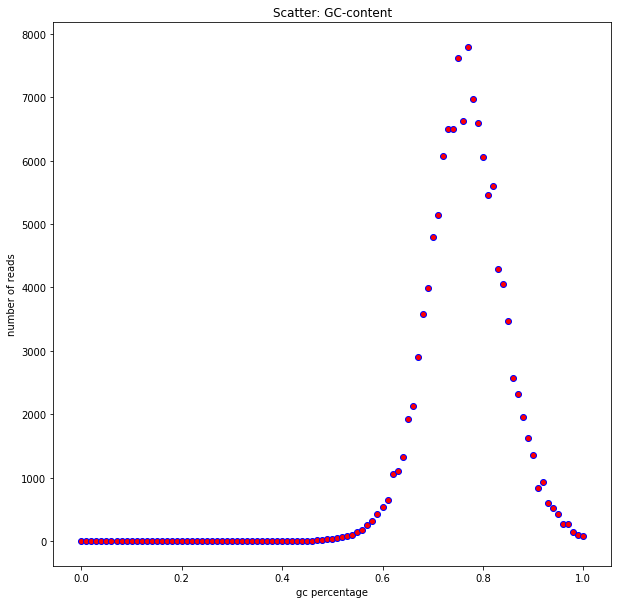

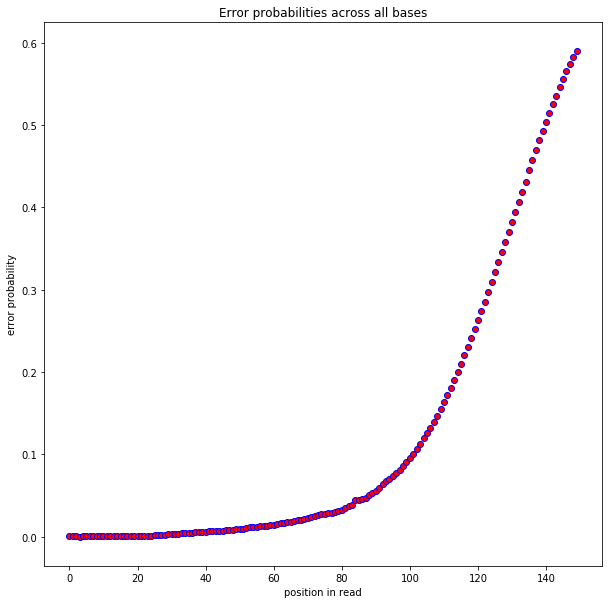

In [61]:
qual, gc_content = read_and_count_fastq('data/frag.R1.fastq')
draw_gc_content(gc_content)
draw_qual(qual)

Посмотрим, что дает FastQC:
![](R1_gc.png)
![](R1_qual.png) 

0 100000 200000 300000 400000 500000 600000 700000 800000 900000 1000000 1100000 1200000 1300000 1400000 1500000 1600000 1700000 

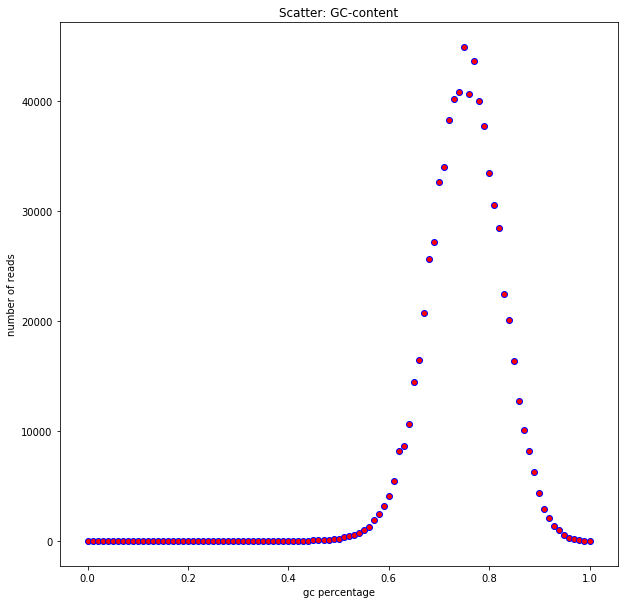

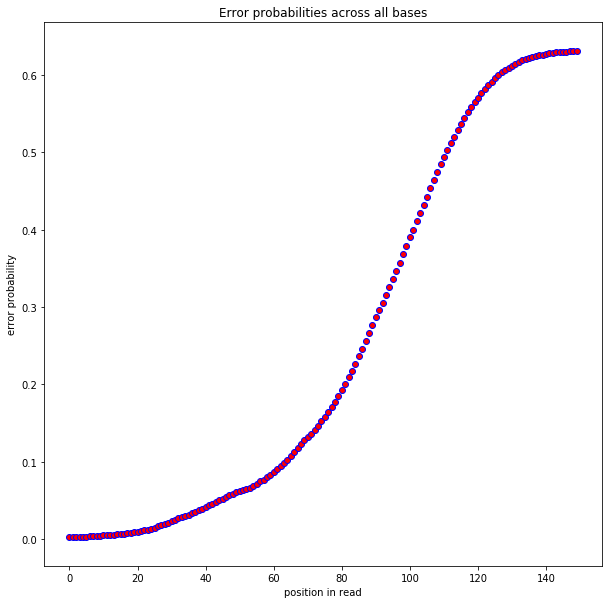

In [63]:
qual, gc_content = read_and_count_fastq('data/frag.R2.fastq')
# qual, seq, gc_content = read_and_count_fastq('data/ttt.fastq')
draw_gc_content(gc_content)
draw_qual(qual)

Посмотрим, что дает FastQC:
![](R2_gc.png)
![](R2_qual.png)
GC-контент получился супер. Error probability вроде тоже ок. (фасткц не рисует именно то, что я рисовал)
P.s. И темперь вероятность ошибки не константа на конце на промежутке, а возрастает все время!!!!!

УРА!